In [1]:
%load_ext autoreload
%autoreload 2

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report
import torch
import sklearn
from WeaponData import WeaponData
from cnn import CnnNet
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import adaptive_leraning_rate
import shap

%config InlineBackend.figure_format = 'svg'



In [2]:
dataset = WeaponData()


['not_weapon', 'weapon']


In [3]:
net = CnnNet(86, len(dataset.classes),  c_kernels=[7, 7, 7, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5], in_channels=[
             3, 16, 32, 64, 86, 128, 128, 128, 128, 128, 128, 128], out_channels=[16, 32, 64, 86, 128, 128, 128, 128, 128, 128, 128, 128])
criterion = nn.NLLLoss()
lr = 0.001
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
loss_test = []


ilość klas: 2
wielkość po warstawach conv: 4


In [4]:
if torch.cuda.is_available():
    net = net.cuda()
    net.cnn = net.cnn.cuda()
    print("GPU is available")
else:
    torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [5]:
def test(dataset, model, criterion):
    total = 0.
    predicted = 0.
    loss_test = 0.
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for data, labels in dataset.testloader:
            labels = labels.cuda()
            data = data.cuda()
            out = model(data)
            predicted_output = torch.argmax(out, dim=1)

            y_true = np.append(y_true, labels.cpu().detach().numpy(), 0)
            y_pred = np.append(y_pred, predicted_output.cpu().detach().numpy(), 0)
            total += labels.shape[0]
            predicted += torch.sum(predicted_output == labels).cpu().item()

            loss = criterion(out, labels)
            loss_test += loss.cpu().item()
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
    return (predicted/total*100), loss_test, confusion_matrix

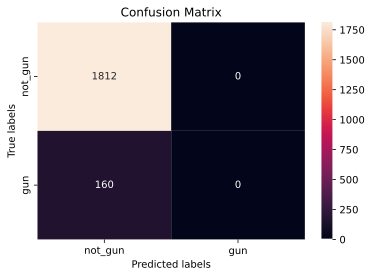

acc: 91.89 %
Learning rate: 0.0010000000
Epoch: 0............. Loss: 0.6824


In [6]:

old_loss = 0
loss_training = []
for e in range(1):
    old_param = net.parameters

    loss_temp = 0
    # pass through all data
    for data, exp in dataset.trainloader:
        exp = exp.cuda()
        # pass data to cuda
        data = data.cuda()
        # clear gradient from previous epoch
        optimizer.zero_grad()
        out = net(data)
        loss = criterion(out, exp)
        loss.backward()
        loss_temp += loss.item()
        optimizer.step()

    loss_training.append(loss_temp)
    acc, loss_test, mat = test(dataset, net, criterion)
    net, optimizer = adaptive_leraning_rate(loss_training[-1], optimizer, net, old_param, old_loss)
    old_loss = loss_training[-1]

    ax= plt.subplot()
    sns.heatmap(mat, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['not_gun', 'gun']); ax.yaxis.set_ticklabels(['not_gun', 'gun']);
    plt.show()
    
    temp_lr: float = optimizer.param_groups[0]['lr']
    print("acc: {:.2f} %".format(acc))
    print("Learning rate: {:.10f}".format(temp_lr))
    print("Epoch: {}.............".format(e), end=" ")
    print("Loss: {:.4f}".format(loss))



Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: index 5 is out of bounds for axis 0 with size 5

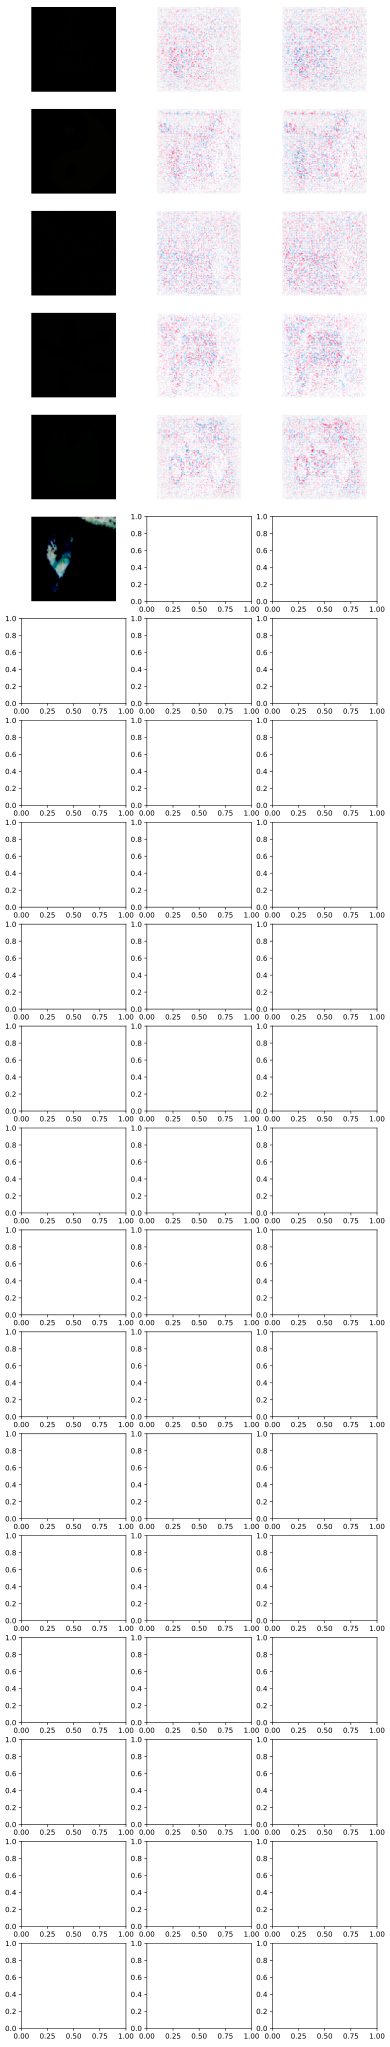

In [9]:
batch = next(iter(dataset.testloader))
images, _ = batch

background = images[:15]
test_images = images[15:]

e = shap.DeepExplainer(net, data)
shap_values = e.shap_values(data)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)
shap.image_plot(shap_numpy, -test_numpy)